In [19]:
import numpy as np
from matplotlib import pyplot as plt

#Задаем функцию FCM алгоритма
#Входные параметры: X - data
#                   n_clusters - кол-во кластеров 
#                   max_iter - максимальное кол-во итераций 
#                   m -  параметр нечеткости
#                   error - критерий остановки
def fcm(X, n_clusters=3, max_iter=1000, m=2, error=1e-5):
    n_samples, n_features = X.shape

    # Инициализируем центры кластеров
    centers = np.random.rand(n_clusters, n_features)

    for _ in range(max_iter):
        # Вычисляем Евклидово расстояние от каждой точки до каждого центра кластера
        distances = euclidean_distance(X, centers)

        # Вычисляем значения функции принадлежности
        membership_probs = calculate_membership_probs(distances, m)

        # Сохраняем предыдущие центры кластеров для проверки критерия остановки
        prev_centers = centers.copy()

        # Вычисляем новые центры кластеров
        for c in range(n_clusters):
            u_pow_m = np.power(membership_probs[:, c], m)
            total = np.sum(u_pow_m)
            centers_c = np.sum(np.multiply(X.T, u_pow_m), axis=1) / total
            centers[c] = centers_c

        # Проверяем критерий остановки
        if np.linalg.norm(centers - prev_centers) < error:
            break

    return centers, np.argmax(membership_probs, axis=1)

#Евклидово расстояние
def euclidean_distance(X, centers):
    distances = np.zeros((X.shape[0], centers.shape[0]))
    for c in range(centers.shape[0]):
        diff = X - centers[c]
        distances[:, c] = np.linalg.norm(diff, axis=1)
    return distances

#Значения функции прандалежности
def calculate_membership_probs(distances, m):
    inv_dist = np.power(1.0 / distances, 2 / (m - 1))
    return inv_dist / np.sum(inv_dist, axis=1, keepdims=True)

# # Изображение данных
# def visualize_clusters(X, predicted_clusters, centers):
#     plt.scatter(X[:, 0], X[:, 1], c=predicted_clusters, cmap='viridis')
#     plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title('Cluster Visualization')
#     plt.show()
    
    

In [20]:
import imageio
# FCM - алгоритм
def get_points(image_filenale: str):
    data = imageio.v3.imread(image_filenale)
    data = 255 - data
    data = (data[:, :, 0] + data[:, :, 1] + data[:, :, 2]) / 3
    return np.transpose(np.asarray(data > 0).nonzero())


# точки для кластеризации должны быть на белом фоне
data = get_points("datac.bmp")

cluster_centers, predicted_clusters = fcm(data, n_clusters=3)
membership_matrix = calculate_membership_probs((euclidean_distance(data, cluster_centers)), m=2)

# Визуализация кластеров
#visualize_clusters(data, predicted_clusters, cluster_centers)

In [21]:
#индекс Се-Бени
def xb(data: np.ndarray, cluster_centers: np.ndarray, membership_matrix: np.ndarray) -> float:
    distances_to_cluster_centers = np.linalg.norm(data[:, None] - cluster_centers, axis=2)
    distances_between_clusters = np.fromfunction(
        lambda i, j: np.linalg.norm(cluster_centers[i.astype(int)] - cluster_centers[j.astype(int)], axis=2),
        (cluster_centers.shape[0], cluster_centers.shape[0]))

    #исключение
    np.fill_diagonal(distances_between_clusters, np.inf)
    min_cluster_center_distance = distances_between_clusters.min()
    return ((membership_matrix**2) * distances_to_cluster_centers).sum() / (data.shape[0] * min_cluster_center_distance)

In [22]:
#Оценка кластерного силуета
def cluster_silhouette_for_object(object_index: int, data: np.ndarray, cluster_results: np.ndarray) -> np.ndarray:
    neighbors = data[np.nonzero(cluster_results == cluster_results[object_index])]
    average_distance_for_neighbors = np.linalg.norm(data[object_index] - neighbors).sum() / neighbors.shape[0]
    
    other_clusters = set(cluster_results[cluster_results != cluster_results[object_index]])
    others_distances = []
    for c in other_clusters:
        other_objects = data[np.nonzero(cluster_results == c)]
        others_distances += [np.linalg.norm(data[object_index] - other_objects).sum() / other_objects.shape[0]]
    min_distance_to_others = min(others_distances)
    return -(average_distance_for_neighbors - min_distance_to_others) / max(average_distance_for_neighbors, min_distance_to_others)


def cluster_silhouette(cluster_index: int, data: np.ndarray, cluster_results: np.ndarray) -> np.ndarray:
    object_indices_for_cluster = np.nonzero(cluster_results == cluster_index)[0]
    return np.array([cluster_silhouette_for_object(i, data, cluster_results) for i in object_indices_for_cluster.tolist()])

In [23]:
#Расчет индекса Се-Бени
xb_index = xb(data, cluster_centers, membership_matrix)
print("Индекс Се-Бени:", xb_index)

Индекс Се-Бени: 0.1711848768513804


In [24]:
#Расчет кластерного силуета
silhouettes = [np.sort(cluster_silhouette(c, data, predicted_clusters))[::-1] for c in set(predicted_clusters)]
silhouettes_indices = [s.sum() / s.shape[0] for s in silhouettes]

/var/folders/46/02_dwctj1bn3gygcl7db3_6r0000gn/T/ipykernel_667/3248586499.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


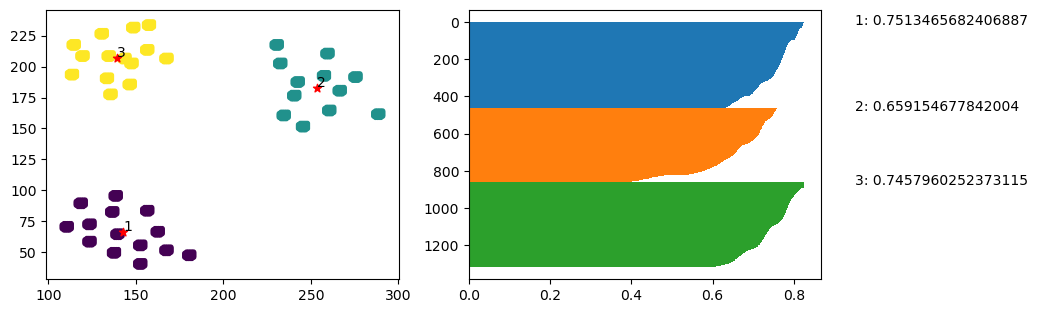

In [25]:
#Изображение
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
plt.gca().invert_yaxis()
ax[0].scatter(data[:, 1], data[:, 0], c=predicted_clusters, marker='.')
ax[0].scatter(cluster_centers[:, 1], cluster_centers[:, 0], c='red', marker='*')

object_counter = 0
cluster_counter = 1
for s in silhouettes:
    ax[0].text(cluster_centers[cluster_counter - 1][1], cluster_centers[cluster_counter - 1][0] + 1, str(cluster_counter))
    ax[1].barh(range(object_counter, object_counter + s.shape[0]), s, height=1)
    ax[1].text(0.95, object_counter + 15, f"{cluster_counter}: {silhouettes_indices[cluster_counter - 1]}")
    object_counter += s.shape[0]
    cluster_counter += 1
fig.show()

Допы

In [ ]:
juliasokolova62@yandex.ru